# Snapshot Graphs
Transmission graphs for an integration. Cleaning WIP

In [1]:
from AD_analysis import *
import Atmospheric_diffraction as atm_shift
import numpy as np
import matplotlib as mpl


The code mainly draws on the following steps, with key variables described:

>analysis=AD_analysis()

This gets the class

====
>analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm) 

This function loads the wavelengths that will be used for the shift calculations. 

First variable is LR or HR

Second variable is NIR or VIS

Third/fourth variables are the start/end bands. These can be the same, e.g. 'B', 'B'.

====
>analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])

OR
>analysis.load_airmasses(HA_range=[0,1,2],targ_dec= 0 * u.degree)
This function loads the airmasses to calculate the shifts for.

Can use 1) zenith angles (ZA_range)
OR 2) hour angles (HA_range); the declination is -25.3 deg by default, change with targ_dec=X

====
>analysis.calculate_shifts(aperturecentre_waveref = 1.1 * u.micron,reposition=True, guide_waveref=5 * u.micron)

This function calculates the shifts for the generated wavelengths and airmasses

aperturecentre_waveref is the aperture wavelength reference for original position

guide_waveref is the telescope guiding wavelength reference

reposition = TRUE or FALSE is a setting that determines whether the aperture is aligned on the aperture wavelength reference for each sequential airmass

====
>analysis.calculate_transmissions(method="numerical moffat") 

This function calculates the transmissions for the shifts using one of several methods

method can be 1) analytical gaussian, 2) numerical gaussian, 3) numerical moffat, or 4) numerical durham

====

These functions can be used in many ways for different plots/analysis of transmissions/shifts

Most of these function have other optional variables, e.g., scale for the numerical simulations, whether to change FWHM with airmass and wavelength. These are described in the relevant function notes

In [2]:
#This function is used to calculate the average transmission over an integration.
#It takes the transmissions for each wavelength from multiple airmasses and averages them.
#This only is a true average of an integration if equally spaced HA have been used.
#This is not true with ZA, as ZA does not increase linearly with time
def observation_transmission(output_parameters):
    integ_transmission=[]
    for i in range(0,len(output_parameters['wave_wavelengths'])):
        trans=0
        for o in range(0,len(output_parameters['wave_transmissions'])):
            trans=trans+output_parameters['wave_transmissions'][o][i]
        trans_mean=trans/len(output_parameters['wave_transmissions'])
        integ_transmission.append(trans_mean)
    return integ_transmission

## Integration Transmission Graphs
### Transmission vs Wavelength for various aperture centres

In [3]:
#Following function plots integration transmission average for single mode observations
def plot_integ_trans(aperture_centres,guide,analysis,normalise="none"):  
    """
    normalise: string, "none", "no ad"
        what to normalise the transmission to; either no normalisation, or relative to the no AD case (perfect ADC)

    """
    weights = np.arange(0, len(aperture_centres)+1)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)

    integ_transmissions=[]
    for aperture_val in aperture_centres:
        analysis.calculate_shifts(aperturecentre_waveref = aperture_val,reposition=False, guide_waveref=guide)
        analysis.calculate_transmissions()
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)

    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions()
    opt_transmission=observation_transmission(analysis.output_parameters)

    plt.figure(figsize=[7,5])
    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i),label='Aperture Centre = {}'.format(aperture_centres[count]),color=cmap.to_rgba(len(aperture_centres)-count))
        plt.ylabel("Mean Transmission")        
        plt.plot(analysis.output_parameters['wave_wavelengths'],opt_transmission,label='No AD Transmission',color='black',linestyle='--')
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_centres[count]),color=cmap.to_rgba(len(aperture_centres)-count))
        plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
        plt.ylabel("Mean Transmission Relative to No AD")
        
    plt.legend()
    plt.ylim(0,1.1)
    plt.xlabel("Wavelength (nm)")
    if analysis.input_parameters['HA_range'] != []:
        plt.title("{} {}, Guiding = {}, HA {}-{}h, Dec = {}".format(analysis.input_parameters['regime'],analysis.input_parameters['band'],guide,analysis.input_parameters['HA_range'][0],analysis.input_parameters['HA_range'][-1],analysis.input_parameters['targ_dec']))
    else:
        plt.title("{} {}, Guiding = {}, Airmass {}-{}".format(analysis.input_parameters['regime'],analysis.input_parameters['band'],guide,analysis.output_parameters['airmasses'][0],analysis.output_parameters['airmasses'][-1]))


Target goes below Horizon above/below HA of +/- 6.0h


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Target goes below Horizon above/below HA of +/- 6.0h


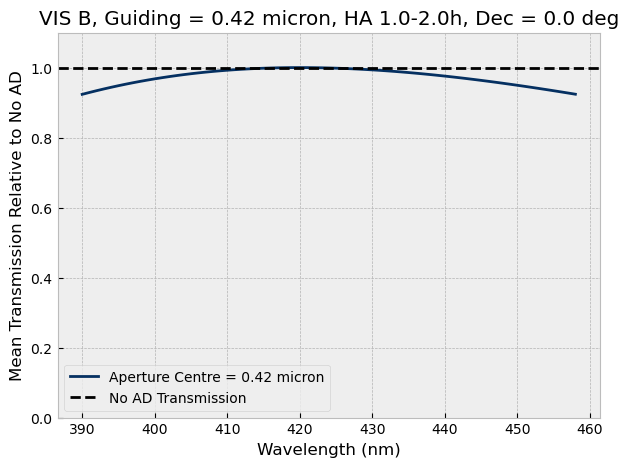

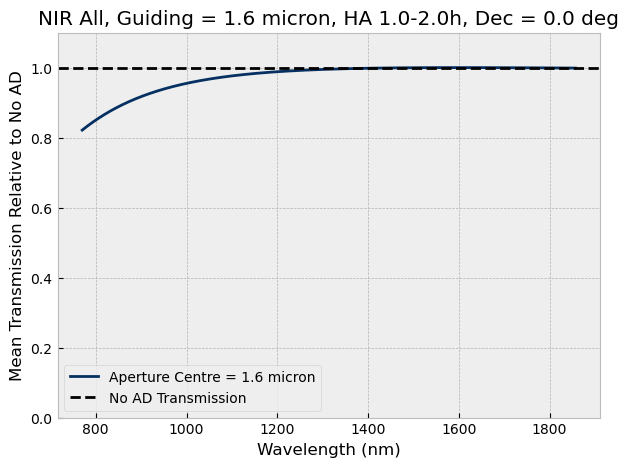

In [4]:
#Following is what is needed to plot the Trans vs Wavelength graphs for various aperture centres
#VIS
analysis=AD_analysis()
analysis.load_wave('LR','VIS','B','B') #Change for wanted observing mode

#Use either airmasses directly or HA; HA is more sensible as it actually scales linearly with time.
#Airmasses directly:
#analysis.load_airmasses(airmasses=np.linspace(1.1,1.3,21))

#HA:
analysis.load_airmasses(HA_range=np.linspace(1,2,21),targ_dec=0*u.deg)

#Aperture values to use:
#aperture_centres=np.around(np.linspace(min(analysis.output_parameters['wave_wavelengths']).to(u.micron).value,max(analysis.output_parameters['wave_wavelengths']).to(u.micron).value,5)*u.micron,3)

analysis.make_aperture("circle",method="numerical moffat")

#Guide in NIR:
guide=1.6 * u.micron
#plot_integ_trans(aperture_centres,guide,analysis,normalise="no AD")

#Guide in VIS:
guide=.42 * u.micron
plot_integ_trans([.42]*u.micron,guide,analysis,normalise="no AD")

#Following is what is needed to plot the Trans vs Wavelength graphs for various aperture centres
#VIS
analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H') #Change for wanted observing mode

#Use either airmasses directly or HA; HA is more sensible as it actually scales linearly with time.
#Airmasses directly:
#analysis.load_airmasses(airmasses=np.linspace(1.1,1.3,21))

#HA:
analysis.load_airmasses(HA_range=np.linspace(1,2,21),targ_dec=0*u.deg)

#Aperture values to use:
#aperture_centres=np.around(np.linspace(min(analysis.output_parameters['wave_wavelengths']).to(u.micron).value,max(analysis.output_parameters['wave_wavelengths']).to(u.micron).value,5)*u.micron,3)

analysis.make_aperture("circle",method="numerical moffat")

#Guide in NIR:
guide=1.6 * u.micron
#plot_integ_trans(aperture_centres,guide,analysis,normalise="no AD")

#Guide in VIS:

plot_integ_trans([1.6]*u.micron,guide,analysis,normalise="no AD")



### Parallel Mode Graph

In [16]:
#Following function plots integration transmission average for parallel observations
def plot_integ_trans_parallel(aperture_B,aperture_V,aperture_R,aperture_NIR,guide,analysis,normalise="none",method="numerical moffat",aperture="circle",sample_val=[1*u.nm,1*u.nm],scale_val=0.01,parallatic=True):  
    weights_r = np.arange(0, len(aperture_NIR)+2)
    norm_r = mpl.colors.Normalize(vmin=min(weights_r), vmax=max(weights_r))
    cmap_red = mpl.cm.ScalarMappable(norm=norm_r, cmap=mpl.cm.Purples)
    weights_b = np.arange(0, len(aperture_B)+2)
    norm_b = mpl.colors.Normalize(vmin=min(weights_b), vmax=max(weights_b))
    cmap_blue = mpl.cm.ScalarMappable(norm=norm_b, cmap=mpl.cm.Blues)
    
    weights_g = np.arange(0, len(aperture_V)+2)
    norm_g = mpl.colors.Normalize(vmin=min(weights_g), vmax=max(weights_g))
    cmap_green = mpl.cm.ScalarMappable(norm=norm_g, cmap=mpl.cm.Greens)
 
    weights_vr = np.arange(0, len(aperture_R)+2)
    norm_vr = mpl.colors.Normalize(vmin=min(weights_vr), vmax=max(weights_vr))
    cmap_vr = mpl.cm.ScalarMappable(norm=norm_vr, cmap=mpl.cm.Reds)
       
    analysis.load_wave("LR","VIS","B","B",sampling=sample_val[0])
    integ_transmissions=[]
    
    for aperture_val in aperture_B:
        analysis.calculate_shifts(aperturecentre_waveref = aperture_val,reposition=False, guide_waveref=guide,parallatic=parallatic)
        analysis.make_aperture(aperture,method,scale_val)
        analysis.calculate_transmissions()
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)

    
    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions()
    opt_transmission=observation_transmission(analysis.output_parameters)

    plt.figure(figsize=[7,5])
    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i),label='Aperture Centre = {}'.format(aperture_B[count]),color=cmap_blue.to_rgba(len(aperture_B)-count))

        plt.plot(analysis.output_parameters['wave_wavelengths'],opt_transmission,color='black',linestyle='--')
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_B[count]),color=cmap_blue.to_rgba(len(aperture_B)-count))

    analysis.load_wave("LR","VIS","V","V",sampling=sample_val[0])
    integ_transmissions=[]
    
    for aperture_val in aperture_V:
        analysis.calculate_shifts(aperturecentre_waveref = aperture_val,reposition=False, guide_waveref=guide,parallatic=parallatic)
        analysis.make_aperture(aperture,method,scale_val)
        analysis.calculate_transmissions()
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)
    
    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions()
    opt_transmission=observation_transmission(analysis.output_parameters)

    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i),label='Aperture Centre = {}'.format(aperture_V[count]),color=cmap_green.to_rgba(len(aperture_V)-count))

        plt.plot(analysis.output_parameters['wave_wavelengths'],opt_transmission,color='black',linestyle='--')
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_V[count]),color=cmap_green.to_rgba(len(aperture_V)-count))
            
    analysis.load_wave("LR","VIS","R","R",sampling=sample_val[0])
    integ_transmissions=[]
    
    for aperture_val in aperture_R:
        analysis.calculate_shifts(aperturecentre_waveref = aperture_val,reposition=False, guide_waveref=guide,parallatic=parallatic)
        analysis.make_aperture(aperture,method,scale_val)
        analysis.calculate_transmissions()
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)
    
    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions()
    opt_transmission=observation_transmission(analysis.output_parameters)

    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i),label='Aperture Centre = {}'.format(aperture_R[count]),color=cmap_vr.to_rgba(len(aperture_R)-count))

        plt.plot(analysis.output_parameters['wave_wavelengths'],opt_transmission,color='black',linestyle='--')
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_R[count]),color=cmap_vr.to_rgba(len(aperture_R)-count))

    analysis.load_wave("LR","NIR","IY","H",sampling=sample_val[1])

    integ_transmissions=[]
    for aperture_val in aperture_NIR:
        analysis.calculate_shifts(aperturecentre_waveref = aperture_val,reposition=False, guide_waveref=guide,parallatic=parallatic)
        analysis.make_aperture(aperture,method,scale_val)
        analysis.calculate_transmissions()
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)

    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions()
    opt_transmission=observation_transmission(analysis.output_parameters)


    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i),label='Aperture Centre = {}'.format(aperture_NIR[count]),color=cmap_red.to_rgba(len(aperture_NIR)-count))
        plt.ylabel("Mean Transmission")        
        plt.plot(analysis.output_parameters['wave_wavelengths'],opt_transmission,label='No AD Transmission',color='black',linestyle='--')
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_NIR[count]),color=cmap_red.to_rgba(len(aperture_NIR)-count))
        plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
        
        plt.ylabel("Mean Transmission Relative to No AD")
        
    plt.ylim(0,1.1)
    plt.xlabel("Wavelength (nm)")
    plt.axvline(x=guide.value*1000,color='black',linewidth=0.7,label='Guiding Wavelength')
    if analysis.input_parameters['HA_range'] != []:
        plt.title("Guiding = {}, HA {}-{}, Dec = {}".format(guide,analysis.input_parameters['HA_range'][0],analysis.input_parameters['HA_range'][-1],analysis.input_parameters['targ_dec']))

    plt.legend()
        


Target goes below Horizon above/below HA of +/- 6.0h
[ 0.         -0.02063155 -0.04069778 -0.0602024  -0.07915079 -0.0975498
 -0.11540755 -0.13273321 -0.14953689 -0.16582942 -0.18162223 -0.19692722
 -0.21175662 -0.22612294 -0.24003878 -0.25351685 -0.26656983 -0.27921034
 -0.29145089 -0.30330379 -0.31478119]


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:127: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


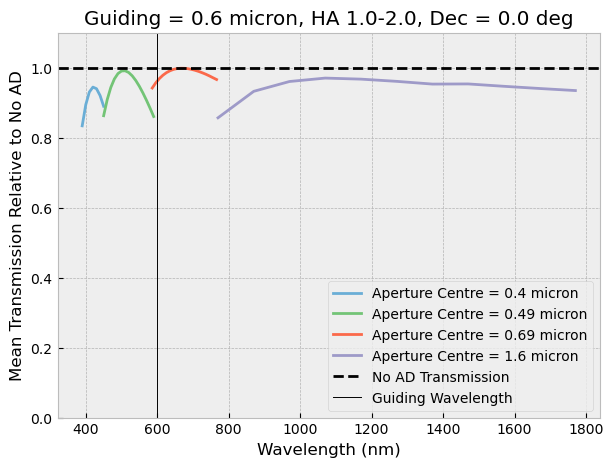

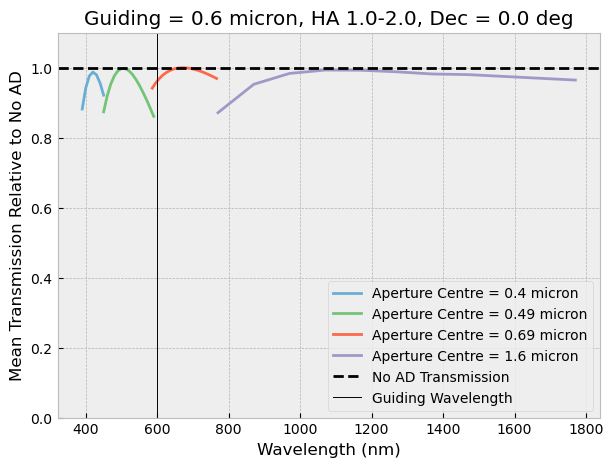

In [21]:
analysis=AD_analysis()

analysis.load_airmasses(HA_range=np.linspace(1,2,21),targ_dec=0*u.deg)

#plot_integ_trans_parallel([.47]*u.micron,[.49,.55]*u.micron,[.6,.7]*u.micron,[1]*u.micron,.6*u.micron,analysis,normalise="no AD",method="numerical moffat",aperture="hexagons",sample_val=[10*u.nm,100*u.nm],scale_val=0.01)


plot_integ_trans_parallel([.4]*u.micron,[.49]*u.micron,[.69]*u.micron,[1.6]*u.micron,.6*u.micron,analysis,normalise="no AD",method="numerical durham",aperture="hexagons",sample_val=[10*u.nm,100*u.nm],scale_val=0.01,parallatic=True)

plot_integ_trans_parallel([.4]*u.micron,[.49]*u.micron,[.69]*u.micron,[1.6]*u.micron,.6*u.micron,analysis,normalise="no AD",method="numerical durham",aperture="hexagons",sample_val=[10*u.nm,100*u.nm],scale_val=0.01,parallatic=False)



Target goes below Horizon above/below HA of +/- 6.0h
[ 0.         -0.02063155 -0.04069778 -0.0602024  -0.07915079 -0.0975498
 -0.11540755 -0.13273321 -0.14953689 -0.16582942 -0.18162223 -0.19692722
 -0.21175662 -0.22612294 -0.24003878 -0.25351685 -0.26656983 -0.27921034
 -0.29145089 -0.30330379 -0.31478119]


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:127: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


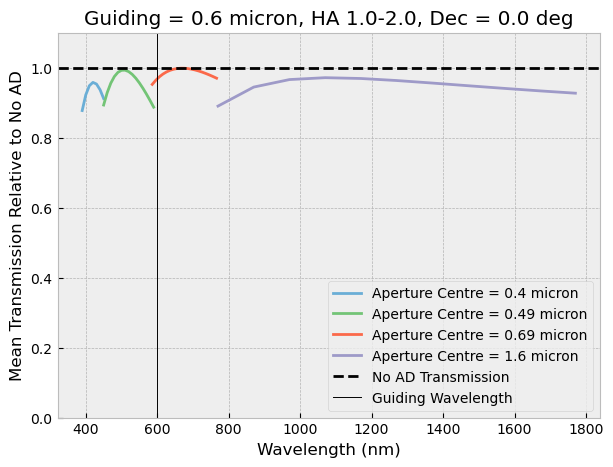

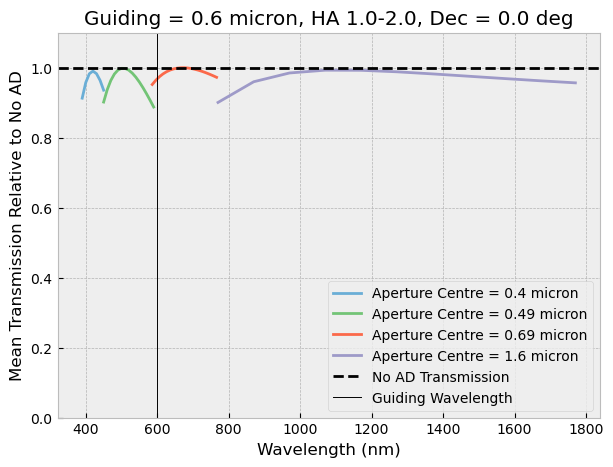

In [22]:
analysis=AD_analysis()

analysis.load_airmasses(HA_range=np.linspace(1,2,21),targ_dec=0*u.deg)

#plot_integ_trans_parallel([.47]*u.micron,[.49,.55]*u.micron,[.6,.7]*u.micron,[1]*u.micron,.6*u.micron,analysis,normalise="no AD",method="numerical moffat",aperture="hexagons",sample_val=[10*u.nm,100*u.nm],scale_val=0.01)


plot_integ_trans_parallel([.4]*u.micron,[.49]*u.micron,[.69]*u.micron,[1.6]*u.micron,.6*u.micron,analysis,normalise="no AD",method="numerical moffat",aperture="hexagons",sample_val=[10*u.nm,100*u.nm],scale_val=0.01,parallatic=True)

plot_integ_trans_parallel([.4]*u.micron,[.49]*u.micron,[.69]*u.micron,[1.6]*u.micron,.6*u.micron,analysis,normalise="no AD",method="numerical moffat",aperture="hexagons",sample_val=[10*u.nm,100*u.nm],scale_val=0.01,parallatic=False)




Target goes below Horizon above/below HA of +/- 6.0h


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:127: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


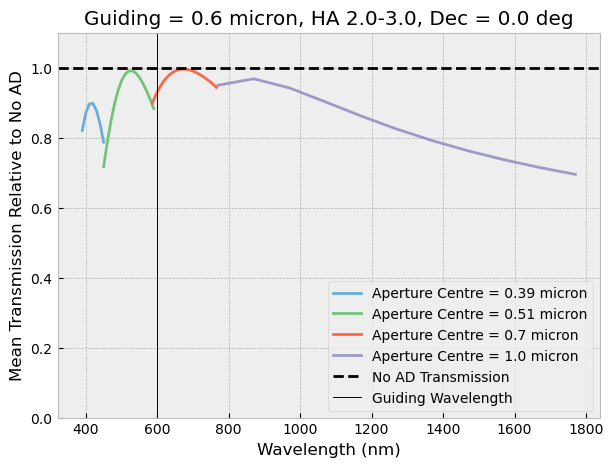

In [7]:
analysis=AD_analysis()

analysis.load_airmasses(HA_range=np.linspace(2,3,2),targ_dec=0*u.deg)

plot_integ_trans_parallel([.39]*u.micron,[.51]*u.micron,[.7]*u.micron,[1]*u.micron,.6*u.micron,analysis,normalise="no AD",method="numerical moffat",aperture="hexagons",sample_val=[10*u.nm,100*u.nm],scale_val=0.01)




Target goes below Horizon above/below HA of +/- 6.0h


AttributeError: 'str' object has no attribute 'to'

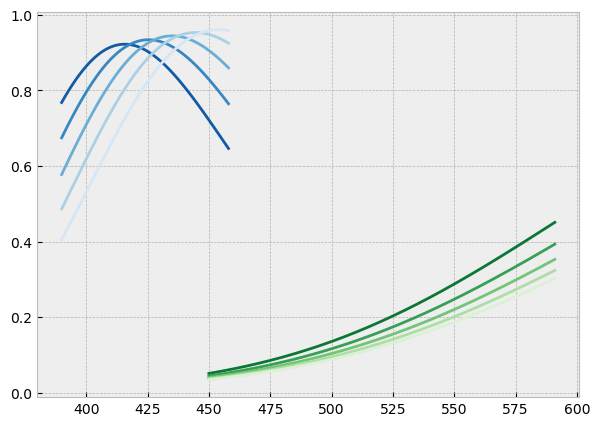

In [8]:
analysis=AD_analysis()

analysis.load_airmasses(HA_range=np.linspace(3,4,21),targ_dec=0*u.deg)

plot_integ_trans_parallel([0.39,.4,.41,.42,.43]*u.micron,[1,1.1,1.2,1.3,1.4]*u.micron,["LR","VIS","B","B"],["LR","NIR","IY","H"],.6*u.micron,analysis,normalise="no AD",method="numerical moffat",aperture="circle",sample_val=[1*u.nm,1*u.nm],scale_val=0.01)


## Spreadsheet ADC Transmissions
Calculation of transmissions for specific shifts from an ADC system for Myriam. Will no longer work due to aperture changes

In [ ]:
import Transmission_calculation as trans
Plate_Scale = 3.316 # [mm/arcsec]
Plate_Scale = Plate_Scale*1000 #um/arcsec
lambdas=[770,859,1010,1045,1370,1420,1670,1926]*u.nm
shifts_0=[0,0,0,0,0,0,0,0] #is in um
shifts_30=np.array([212,141,60,50,35,42,100,195])
shifts_45=np.array([366,243,104,87,61,72,173,338])
shifts_50=np.array([436,289,124,103,72,86,205,402])
shifts_60=np.array([633,420,179,150,105,125,298,584])
shifts=np.array([shifts_0,shifts_30,shifts_45,shifts_50,shifts_60])/Plate_Scale*u.arcsec


In [ ]:
analysis=AD_analysis()
analysis.output_parameters['wave_wavelengths']=lambdas
analysis.load_airmasses(ZA_range=[0,30,45,50,60])
analysis.output_parameters['shifts']=shifts
analysis.output_parameters['aperture_diameter']=0.6*u.arcsec
analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)

raw_trans=analysis.output_parameters['wave_transmissions']

ZA_vals=[0,30,45,50,60]
analysis=AD_analysis()
analysis.output_parameters['wave_wavelengths']=lambdas

analysis.output_parameters['shifts']=[shifts_0]*u.arcsec
analysis.output_parameters['aperture_diameter']=0.6*u.arcsec
for i in range(0,len(ZA_vals)):
    analysis.load_airmasses(ZA_range=[ZA_vals[i]])
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)
    print("Raw Transmission for ZA = {} for ADC shifts:".format(ZA_vals[i]))
    rounded_vals = [ round(val,3) for val in raw_trans[i]]
    print(rounded_vals)
    normalised_vals=(np.array(raw_trans)[i]/np.array(analysis.output_parameters['wave_transmissions'][0]))
    print("Transmission relative to no AD for ZA = {} for ADC shifts:".format(ZA_vals[i]))
    normalised_vals = [round(elem,3) for elem in normalised_vals]
    print(normalised_vals)
    print("==========================================================")
    

In [ ]:
import Transmission_calculation as trans
Plate_Scale = 3.316 # [mm/arcsec]
Plate_Scale = Plate_Scale*1000 #um/arcsec
lambdas=[770,859,1010,1045,1370,1420,1670,1926]*u.nm
shifts_0=[0,0,0,0,0,0,0,0] #is in um
shifts_30=np.array([210.00,188.00,141.00,129.00,0.00,-23.00,-148.00,-298.00])
shifts_45=np.array([474.00,348.00,252.00,229.00,0.00,-38.00,-248.00,-496.00])
shifts_50=np.array([483.00,416.00,300.00,273.00,0.00,-46.00,-295.00,-589.00])
shifts_60=np.array([696.00,602.00,435.00,395.00,0.00,-67.00,-428.00,-856.00])
shifts=np.array([shifts_0,shifts_30,shifts_45,shifts_50,shifts_60])/Plate_Scale*u.arcsec


In [ ]:
analysis=AD_analysis()
analysis.output_parameters['wave_wavelengths']=lambdas
analysis.load_airmasses(ZA_range=[0,30,45,50,60])
analysis.output_parameters['shifts']=shifts
analysis.output_parameters['aperture_diameter']=0.6*u.arcsec
analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)

raw_trans=analysis.output_parameters['wave_transmissions']

ZA_vals=[0,30,45,50,60]

weights = np.arange(0, len(ZA_vals)+1)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)

analysis=AD_analysis()
analysis.output_parameters['wave_wavelengths']=lambdas

analysis.output_parameters['shifts']=[shifts_0]*u.arcsec
analysis.output_parameters['aperture_diameter']=0.6*u.arcsec
plt.figure(figsize=[8,5])
for i in range(0,len(ZA_vals)):
    analysis.load_airmasses(ZA_range=[ZA_vals[i]])
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)
    print("Raw Transmission for ZA = {} for ADC shifts:".format(ZA_vals[i]))
    rounded_vals = [ round(val,3) for val in raw_trans[i]]
    print(rounded_vals)
    normalised_vals=(np.array(raw_trans)[i]/np.array(analysis.output_parameters['wave_transmissions'][0]))
    print("Transmission relative to no AD for ZA = {} for ADC shifts:".format(ZA_vals[i]))
    normalised_vals = [round(elem,3) for elem in normalised_vals]
    print(normalised_vals)
    print("==========================================================")
    plt.plot(lambdas,normalised_vals,label="ZA = {}".format(ZA_vals[i]),color=cmap.to_rgba(len(ZA_vals)+1-i))
plt.ylim(0,1.1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission Relative to no AD")
plt.legend()
plt.title("NIR Transmission Curves vs Wavelength for Various ZA, Global ADC")

plt.figure(figsize=[8,5])
for i in range(0,len(ZA_vals)):
    analysis.load_airmasses(ZA_range=[ZA_vals[i]])
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)

    rounded_vals = [ round(val,3) for val in raw_trans[i]]

    normalised_vals=(np.array(raw_trans)[i]/np.array(raw_trans)[i][4])

    normalised_vals = [round(elem,3) for elem in normalised_vals]

    plt.plot(lambdas,normalised_vals,label="ZA = {}".format(ZA_vals[i]),color=cmap.to_rgba(i))
plt.ylim(0,1.4)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission relative to Aperture Centre Wavelength")
plt.legend()
plt.title("NIR Transmission Curves vs Wavelength for Various ZA, Global ADC")

In [ ]:
import Transmission_calculation as trans
Plate_Scale = 3.316 # [mm/arcsec]
Plate_Scale = Plate_Scale*1000 #um/arcsec
lambdas=[390,487,627,770,859]*u.nm
shifts_0=[0,0,0,0,0] #is in um
shifts_30=np.array([151.00,0.00,83.00,67.00,45.00])
shifts_45=np.array([473.00,0.00,41.00,41.00,85.00])
shifts_50=np.array([543.00,0.00,36.00,55.00,122.00])
shifts_60=np.array([771.00,0.00,105.00,22.00,116.00])
shifts=np.array([shifts_0,shifts_30,shifts_45,shifts_50,shifts_60])/Plate_Scale*u.arcsec
print(shifts)

In [ ]:
analysis=AD_analysis()
analysis.output_parameters['wave_wavelengths']=lambdas
analysis.load_airmasses(ZA_range=[0,30,45,50,60])
analysis.output_parameters['shifts']=shifts
analysis.output_parameters['aperture_diameter']=0.69*u.arcsec
analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)

raw_trans=analysis.output_parameters['wave_transmissions']

ZA_vals=[0,30,45,50,60]

weights = np.arange(0, len(ZA_vals)+1)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)

analysis=AD_analysis()
analysis.output_parameters['wave_wavelengths']=lambdas

analysis.output_parameters['shifts']=[shifts_0]*u.arcsec
analysis.output_parameters['aperture_diameter']=0.69*u.arcsec
plt.figure(figsize=[8,5])
for i in range(0,len(ZA_vals)):
    analysis.load_airmasses(ZA_range=[ZA_vals[i]])
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)
    print("Raw Transmission for ZA = {} for ADC shifts:".format(ZA_vals[i]))
    rounded_vals = [ round(val,3) for val in raw_trans[i]]
    print(rounded_vals)
    normalised_vals=(np.array(raw_trans)[i]/np.array(analysis.output_parameters['wave_transmissions'][0]))
    print("Transmission relative to no AD for ZA = {} for ADC shifts:".format(ZA_vals[i]))
    normalised_vals = [round(elem,3) for elem in normalised_vals]
    print(normalised_vals)
    print("==========================================================")
    plt.plot(lambdas,normalised_vals,label="ZA = {}".format(ZA_vals[i]),color=cmap.to_rgba(len(ZA_vals)+1-i))
plt.ylim(0,1.1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission Relative to no AD")
plt.legend()
plt.title("VIS Transmission Curves vs Wavelength for Various ZA, Global ADC")

plt.figure(figsize=[8,5])
for i in range(0,len(ZA_vals)):
    analysis.load_airmasses(ZA_range=[ZA_vals[i]])
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)

    rounded_vals = [ round(val,3) for val in raw_trans[i]]

    normalised_vals=(np.array(raw_trans)[i]/np.array(np.array(raw_trans)[i][1]))

    normalised_vals = [round(elem,3) for elem in normalised_vals]

    plt.plot(lambdas,normalised_vals,label="ZA = {}".format(ZA_vals[i]),color=cmap.to_rgba(i))
plt.ylim(0,1.4)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission relative to Aperture Centre Wavelength")
plt.legend()
plt.title("VIS Transmission Curves vs Wavelength for Various ZA, Global ADC")

In [ ]:
za_airmasses=[atm_diff.zenith_dist_to_airmass(0),atm_diff.zenith_dist_to_airmass(30),atm_diff.zenith_dist_to_airmass(45),atm_diff.zenith_dist_to_airmass(50),atm_diff.zenith_dist_to_airmass(60)]
HA_vals=np.linspace(1,2,21)
airmasses=atm_diff.zenith_dist_to_airmass(atm_diff.HA_2_ZA(HA_vals,dec=0*u.deg))
airmasses_prime=atm_diff.zenith_dist_to_airmass(atm_diff.HA_2_ZA(HA_vals,dec=0*u.deg))

import Transmission_calculation as trans
Plate_Scale = 3.316 # [mm/arcsec]
Plate_Scale = Plate_Scale*1000 #um/arcsec
lambdas=[390,487,627,770,859]*u.nm
shifts_0=[0,0,0,0,0] #is in um
shifts_30=np.array([151.00,0.00,83.00,67.00,45.00])
shifts_45=np.array([473.00,0.00,41.00,41.00,85.00])
shifts_50=np.array([543.00,0.00,36.00,55.00,122.00])
shifts_60=np.array([771.00,0.00,105.00,22.00,116.00])
shifts=np.array([shifts_0,shifts_30,shifts_45,shifts_50,shifts_60])/Plate_Scale*u.arcsec

In [ ]:
shiftz_0=(shifts_30-shifts_0)*(airmasses[0]-za_airmasses[0])/(za_airmasses[1]-za_airmasses[0])+shifts_0
shiftz_1=(shifts_30-shifts_0)*(airmasses[1]-za_airmasses[0])/(za_airmasses[1]-za_airmasses[0])+shifts_0
shiftz_2=(shifts_30-shifts_0)*(airmasses[2]-za_airmasses[0])/(za_airmasses[1]-za_airmasses[0])+shifts_0
shiftz_3=(shifts_30-shifts_0)*(airmasses[3]-za_airmasses[0])/(za_airmasses[1]-za_airmasses[0])+shifts_0

total_shifts=[shiftz_0,shiftz_1,shiftz_2,shiftz_3]

for i in range(4,21):
    this_shift=(shifts_45-shifts_30)*(airmasses[i]-za_airmasses[1])/(za_airmasses[2]-za_airmasses[1])+shifts_30
    total_shifts.append(this_shift)
    
total_shifts = np.array(total_shifts)/Plate_Scale*u.arcsec


In [ ]:
analysis=AD_analysis()
analysis.output_parameters['wave_wavelengths']=lambdas
analysis.load_airmasses(HA_range=HA_vals,targ_dec=0*u.deg)
analysis.output_parameters['shifts']=total_shifts * u.arcsec
analysis.output_parameters['aperture_diameter']=0.69*u.arcsec
analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)

raw_trans=analysis.output_parameters['wave_transmissions']
integ_transmission=observation_transmission(analysis.output_parameters)
optimum_trans_=np.array([0,0,0,0,0])
analysis=AD_analysis()
analysis.output_parameters['wave_wavelengths']=lambdas

analysis.output_parameters['shifts']=[shifts_0] * u.arcsec
analysis.output_parameters['aperture_diameter']=0.69*u.arcsec
for i in range(0,len(HA_vals)):
    analysis.load_airmasses(HA_range=[HA_vals[i]],targ_dec=0*u.deg)
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)
    optimum_trans_=optimum_trans_+np.array(analysis.output_parameters['wave_transmissions'])/21

plt.figure(figsize=[8,5])
plt.plot(lambdas,(integ_transmission/optimum_trans_)[0],color='blue')
plt.ylim(0,1.1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission Relative to no AD")
plt.title("VIS With Global ADC, Guide = 487nm, HA 1-2h, Dec = 0 deg")

In [ ]:
za_airmasses=[atm_diff.zenith_dist_to_airmass(0),atm_diff.zenith_dist_to_airmass(30),atm_diff.zenith_dist_to_airmass(45),atm_diff.zenith_dist_to_airmass(50),atm_diff.zenith_dist_to_airmass(60)]
HA_vals=np.linspace(1,2,21)
airmasses=atm_diff.zenith_dist_to_airmass(atm_diff.HA_2_ZA(HA_vals,dec=0*u.deg))
airmasses_prime=atm_diff.zenith_dist_to_airmass(atm_diff.HA_2_ZA(HA_vals,dec=0*u.deg))


import Transmission_calculation as trans
Plate_Scale = 3.316 # [mm/arcsec]
Plate_Scale = Plate_Scale*1000 #um/arcsec
lambdas=[770,859,1010,1045,1370,1420,1670,1926]*u.nm
shifts_0=[0,0,0,0,0,0,0,0] #is in um
shifts_30=np.array([210.00,188.00,141.00,129.00,0.00,-23.00,-148.00,-298.00])
shifts_45=np.array([474.00,348.00,252.00,229.00,0.00,-38.00,-248.00,-496.00])
shifts_50=np.array([483.00,416.00,300.00,273.00,0.00,-46.00,-295.00,-589.00])
shifts_60=np.array([696.00,602.00,435.00,395.00,0.00,-67.00,-428.00,-856.00])
shifts=np.array([shifts_0,shifts_30,shifts_45,shifts_50,shifts_60])/Plate_Scale*u.arcsec

shiftz_0=(shifts_30-shifts_0)*(airmasses[0]-za_airmasses[0])/(za_airmasses[1]-za_airmasses[0])+shifts_0
shiftz_1=(shifts_30-shifts_0)*(airmasses[1]-za_airmasses[0])/(za_airmasses[1]-za_airmasses[0])+shifts_0
shiftz_2=(shifts_30-shifts_0)*(airmasses[2]-za_airmasses[0])/(za_airmasses[1]-za_airmasses[0])+shifts_0
shiftz_3=(shifts_30-shifts_0)*(airmasses[3]-za_airmasses[0])/(za_airmasses[1]-za_airmasses[0])+shifts_0

total_shifts=[shiftz_0,shiftz_1,shiftz_2,shiftz_3]

for i in range(4,21):
    this_shift=(shifts_45-shifts_30)*(airmasses[i]-za_airmasses[1])/(za_airmasses[2]-za_airmasses[1])+shifts_30
    total_shifts.append(this_shift)
    
total_shifts = np.array(total_shifts)/Plate_Scale*u.arcsec

In [ ]:
analysis=AD_analysis()
analysis.output_parameters['wave_wavelengths']=lambdas
analysis.load_airmasses(HA_range=HA_vals,targ_dec=0*u.deg)
analysis.output_parameters['shifts']=total_shifts * u.arcsec
analysis.output_parameters['aperture_diameter']=0.6*u.arcsec
analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)

raw_trans=analysis.output_parameters['wave_transmissions']
integ_transmission=observation_transmission(analysis.output_parameters)
optimum_trans_=np.array([0,0,0,0,0,0,0,0])
analysis=AD_analysis()
analysis.output_parameters['wave_wavelengths']=lambdas

analysis.output_parameters['shifts']=[shifts_0] * u.arcsec
analysis.output_parameters['aperture_diameter']=0.6*u.arcsec
for i in range(0,len(HA_vals)):
    analysis.load_airmasses(HA_range=[HA_vals[i]],targ_dec=0*u.deg)
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)
    optimum_trans_=optimum_trans_+np.array(analysis.output_parameters['wave_transmissions'])/21

plt.figure(figsize=[8,5])
plt.plot(lambdas,(integ_transmission/optimum_trans_)[0],color='red')
plt.ylim(0,1.1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission Relative to no AD")
plt.title("NIR With Global ADC, Guide = 1370nm, HA 1-2h, Dec = 0 deg")

In [ ]:
shifts=np.array([3,4,4,6])
angles=np.array([0,30,30,6])

In [ ]:
print(shifts**2+3**2-2*shifts*3*np.cos(angles))

In [ ]:
np.cos(angles)